In [1]:
%pylab inline
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import preprocessing, cross_validation
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/vsquared/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load data

In [2]:
analytic_base = pd.read_csv('~/Repositories/datasets/analytic_base.csv')

In [3]:
analytic_qgiv = pd.read_csv('~/Repositories/datasets/analytic_qgiv_stats.csv')

In [4]:
print analytic_base.columns.values
print analytic_qgiv.columns.values

['sic' 'ein' 'timestamp' 'id' 'org' 'form' 'visits' 'mobile_visits'
 'vt_trans_count' 'don_form_trans_count' 'kiosk_trans_count'
 'p2p_trans_count' 'mobile_trans_count' 'mobilevt_trans_count'
 'sms_trans_count' 'fb_trans_count' 'vt_trans_vol' 'don_form_trans_vol'
 'kiosk_trans_vol' 'p2p_trans_vol' 'mobile_trans_vol' 'mobilevt_trans_vol'
 'sms_trans_vol' 'fb_trans_vol' 'one_time_trans_count' 'one_time_trans_vol'
 'rec_trans_count' 'rec_trans_vol']
['id' 'base' 'org' 'event_stats' 'new_rec_volume' 'new_rec_count'
 'reg_volume' 'reg_count' 'dl_trans_volume' 'dl_trans_count'
 'dl_new_rec_count' 'dl_new_rec_volume' 'total_visits' 'visits_mobile'
 'pledges_count' 'events_priv_count' 'events_count' 'restrictions'
 'amounts' 'ded_types' 'opt_ded_flds' 'req_ded_flds' 'opt_fields'
 'req_fields' 'pledge_active' 'donation_active' 'amounts_system'
 'multirestriction_system' 'min_amount' 'max_amount' 'show_amount'
 'permit_international' 'permit_anonymous' 'permit_mobile'
 'permit_recurring' 'permit

In [5]:
ab = analytic_base[['id', 'org', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol']]
aq = analytic_qgiv[['id', 'base', 'org', 'total_visits', 'opt_fields', 'req_fields', 'donation_active', 'amounts_system', 'multirestriction_system', 'restrictions', 'pledges_count', 'pledge_active', 'permit_anonymous', 'permit_mobile', 'permit_other_amount', 'enable_donorlogins', 'collect_captcha']]
d = pd.merge(ab, aq, left_on="id", right_on="base")

## cleanup & create conversion column

In [6]:
# filter out not visited observations
data = d[d.visits > 0]
# add conversion
conversion = pd.DataFrame({'conversion':data["don_form_trans_count"]/data["total_visits"]*100})
# merge conversion w/ the rest of the data
data = pd.concat([data, conversion], axis=1)
# add day_of_month & month
date_data = pd.DataFrame({
        'day': pd.to_datetime(data.timestamp).apply(lambda x: x.day), 
        'month': pd.to_datetime(data.timestamp).apply(lambda x: x.month)})
# merge date data w/ the rest of the data
data = pd.concat([data, date_data], axis=1)

In [7]:
data.columns.values

array(['id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits',
       'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base',
       'org_y', 'total_visits', 'opt_fields', 'req_fields',
       'donation_active', 'amounts_system', 'multirestriction_system',
       'restrictions', 'pledges_count', 'pledge_active',
       'permit_anonymous', 'permit_mobile', 'permit_other_amount',
       'enable_donorlogins', 'collect_captcha', 'conversion', 'day',
       'month'], dtype=object)

In [8]:
data['conversion'].describe()

count    569722.000000
mean          2.196590
std          15.172242
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2600.000000
Name: conversion, dtype: float64

## restrictions v conversion

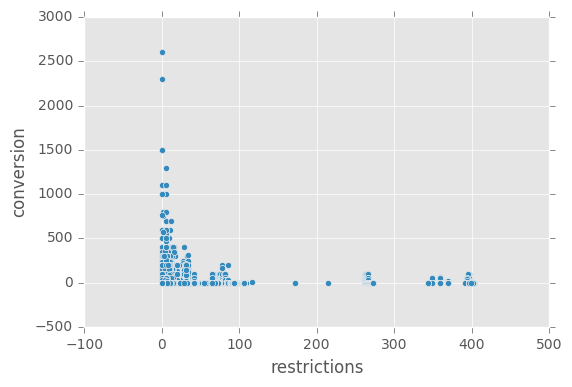

In [9]:
plt.figure()
data.plot.scatter(x='restrictions', y='conversion')
#plt.plot(data.restrictions, data.conversion, 'b.')
plt.show()

## optional fields v conversion

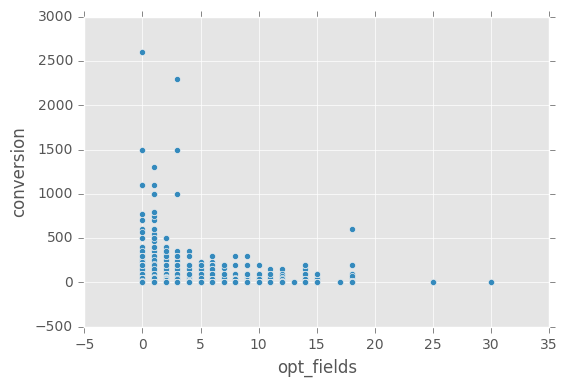

In [10]:
data.plot.scatter(x='opt_fields', y='conversion')

## required fields v conversion

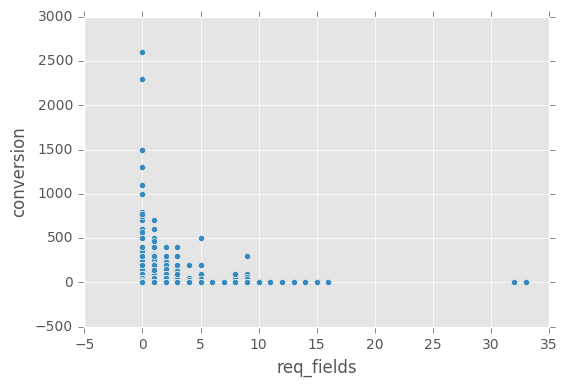

In [11]:
data.plot.scatter(x='req_fields', y='conversion')

## Multivariate model

__Data columns__

'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits',
'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base',
'org_y', 'total_visits', 'opt_fields', 'req_fields',
'donation_active', 'amounts_system', 'multirestriction_system',
'restrictions', 'pledges_count', 'pledge_active',
'permit_anonymous', 'permit_mobile', 'permit_other_amount',
'enable_donorlogins', 'collect_captcha', 'conversion', 'day', 'month'

In [12]:
features = data.copy()

# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'conversion']
for i_to_remove in to_remove:
    del features[i_to_remove]

# add restrictionsXmultirestriction interaction term, restrictions^2, opt_fields^2, req_fields^2
features['restrictionsXmultirestriction'] = features.restrictions*features.multirestriction_system
features['restrictions2'] = features.restrictions*features.restrictions
features['opt_fields2'] = features.opt_fields*features.opt_fields
features['req_fields2'] = features.req_fields*features.req_fields
features['restrictions2Xmultirestriction'] = features.restrictions*features.restrictions*features.multirestriction_system
features['fields'] = features['opt_fields'] + features['req_fields']
features['fields2'] = features['fields']*features['fields']

# normalize features
features_scaled = preprocessing.scale(features)

## Train regression models

In [13]:
mdl = linear_model.LinearRegression()
mdl.fit(features, data.conversion)

mdl_scaled = linear_model.LinearRegression()
mdl_scaled.fit(features_scaled, data.conversion)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
print "SCALED COEFFECIENTS:"
scaled_coeff = {}
scaled_coeff["intercept"] = mdl_scaled.intercept_
for i in range(0, 21):
    scaled_coeff[features.columns[i]] = mdl_scaled.coef_[i]
for i in scaled_coeff:
    print i+": "+str(scaled_coeff[i])

print "\n\nSCALED COEFFICIENTS, SORTED - ASCENDING VALUES:"

scaled_coeff = {}
scaled_coeff["intercept"] = mdl_scaled.intercept_
for i in range(0, 21):
    scaled_coeff[features.columns[i]] = mdl_scaled.coef_[i]

import operator
sorted_scaled_coeff = sorted(scaled_coeff.items(), key=operator.itemgetter(1))
for i in sorted_scaled_coeff:
    print i[0]+": "+str(i[1])

SCALED COEFFECIENTS:
restrictions2Xmultirestriction: -0.170030623674
enable_donorlogins: 0.37807880342
month: -0.148633718491
req_fields2: 0.0449747405946
permit_mobile: 0.19244030118
pledges_count: 0.12838602066
donation_active: 0.58625793457
permit_anonymous: -0.0675761699677
collect_captcha: 999.246247143
fields2: -0.21182101965
restrictionsXmultirestriction: 0.361891567707
opt_fields2: 0.0138292908669
opt_fields: -9007038651.95
restrictions2: -0.917884230614
intercept: 2.19659022646
day: 0.183929413557
restrictions: 0.907587528229
fields: 10647872617.3
req_fields: -4676165163.98
pledge_active: -0.370208501816
permit_other_amount: 0.0553512275219
multirestriction_system: 0.891786575317


SCALED COEFFICIENTS, SORTED - ASCENDING VALUES:
opt_fields: -9007038651.95
req_fields: -4676165163.98
restrictions2: -0.917884230614
pledge_active: -0.370208501816
fields2: -0.21182101965
restrictions2Xmultirestriction: -0.170030623674
month: -0.148633718491
permit_anonymous: -0.0675761699677
opt_fi

### Testing fitted model against increasing restriction counts for a form using multirestriction system

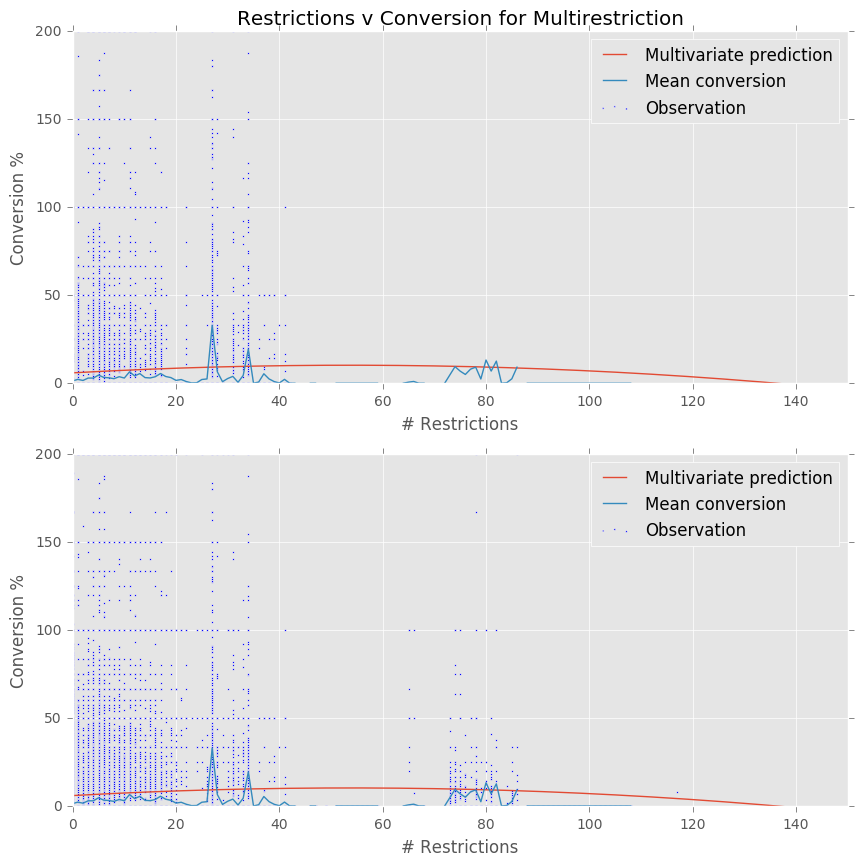

In [15]:
# generate prediction data
example = data[data.conversion>0][1:2]
example['restrictionsXmultirestriction'] = example.restrictions*example.multirestriction_system
example['restrictions2'] = example.restrictions*example.restrictions
example['opt_fields2'] = example.opt_fields*example.opt_fields
example['req_fields2'] = example.req_fields*example.req_fields

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['restrictions'] = i
    example['restrictionsXmultirestriction'] = i
    example['restrictions2'] = i*i
    example['restrictions2Xmultirestriction'] = i*i
    example['fields'] = example['opt_fields'] + example['req_fields']
    example['fields2'] = example['fields']*example['fields']
    predictions.append(mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(data[data.restrictions==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(10,10))
plt.subplot(211)
plt.scatter(data[data.multirestriction_system==1.0].restrictions, data[data.multirestriction_system==1.0].conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Restrictions v Conversion for Multirestriction")
xlim(0, 150)
ylim(0, 200)
xlabel('# Restrictions')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(data.restrictions, data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
xlim(0, 150)
ylim(0, 200)
xlabel('# Restrictions')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()

In [16]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, data.conversion, test_size=0.2, random_state=0)

scores = mdl.score(x_test, y_test)
print scores

0.0115011088883


### Testing fitted model against increasing required field count

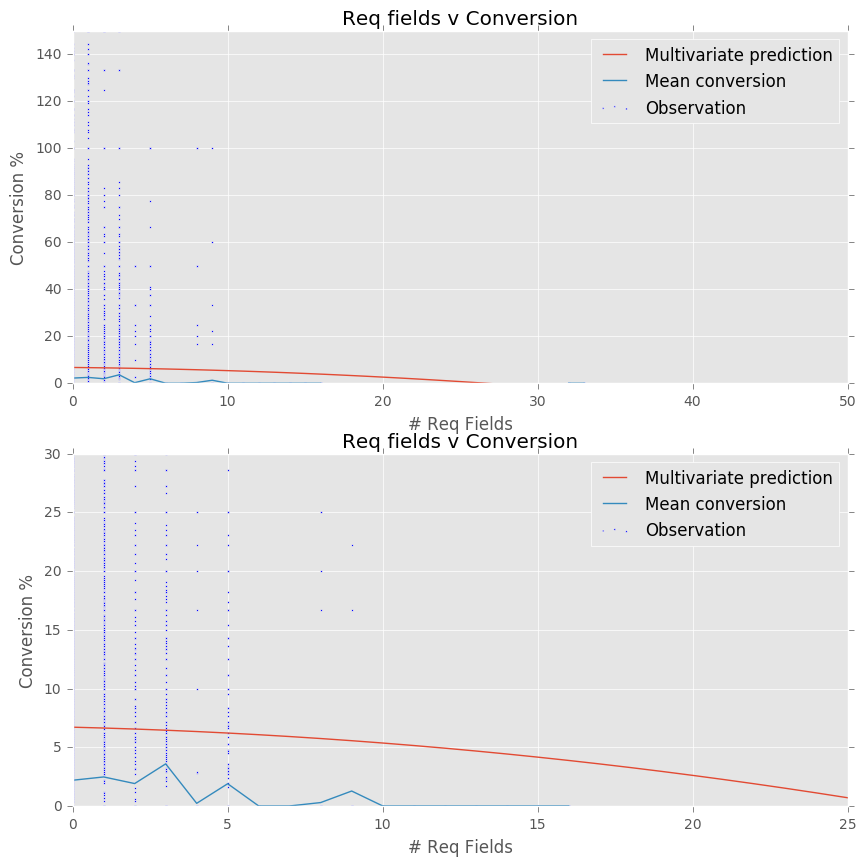

In [17]:
# generate prediction data
example = data[data.conversion>0][1:2]
example['restrictionsXmultirestriction'] = example.restrictions*example.multirestriction_system
example['restrictions2'] = example.restrictions*example.restrictions
example['restrictions2Xmultirestriction'] = example['restrictionsXmultirestriction']*example['restrictionsXmultirestriction']
example['opt_fields2'] = example.opt_fields*example.opt_fields

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 50):
    example['req_fields'] = i
    example['req_fields2'] = i*i
    example['fields'] = example['opt_fields'] + i
    example['fields2'] = example['fields']*example['fields']
    predictions.append(mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 50):
    mean_conversion.append(data[data.req_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(10,10))
plt.subplot(211)
plt.scatter(data.req_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 50), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 50), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Req fields v Conversion")
xlim(0, 50)
ylim(0, 150)
xlabel('# Req Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(data.req_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 50), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 50), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Req fields v Conversion")
xlim(0, 25)
ylim(0, 30)
xlabel('# Req Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()

### Testing fitted model against increasing optional field count

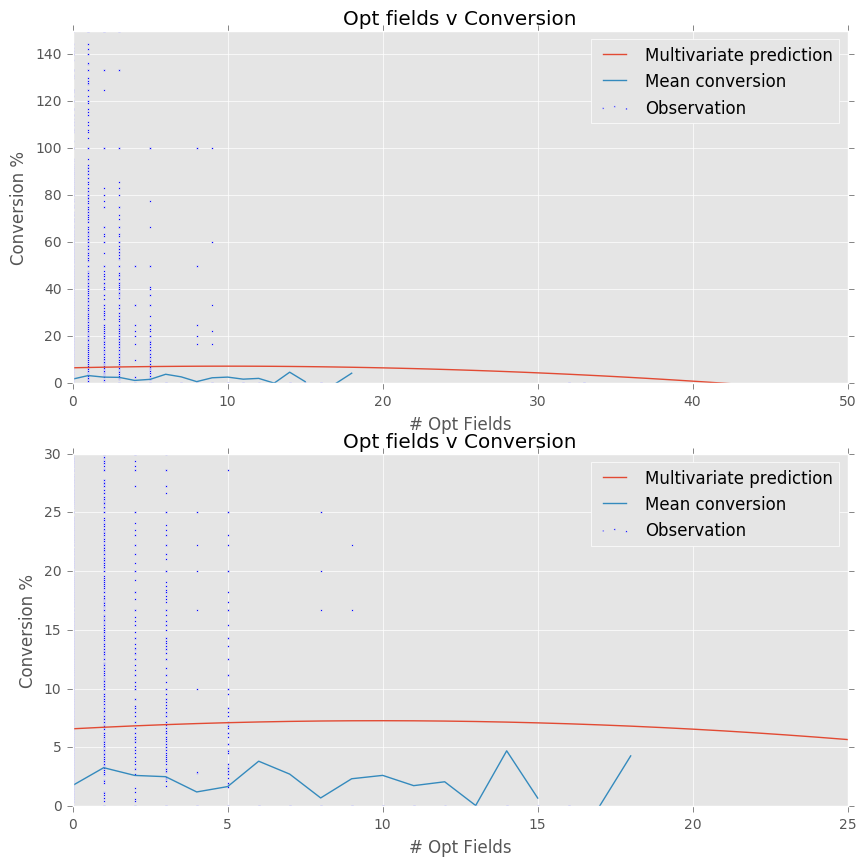

In [18]:
# generate prediction data
example = data[data.conversion>0][1:2]
example['restrictionsXmultirestriction'] = example.restrictions*example.multirestriction_system
example['restrictions2'] = example.restrictions*example.restrictions
example['restrictions2Xmultirestriction'] = example['restrictionsXmultirestriction']*example['restrictionsXmultirestriction']
example['req_fields2'] = example.req_fields*example.req_fields

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 50):
    example['opt_fields'] = i
    example['opt_fields2'] = i*i
    example['fields'] = example['req_fields'] + i
    example['fields2'] = example['fields']*example['fields']
    predictions.append(mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 50):
    mean_conversion.append(data[data.opt_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(10,10))
plt.subplot(211)
plt.scatter(data.req_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 50), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 50), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Opt fields v Conversion")
xlim(0, 50)
ylim(0, 150)
xlabel('# Opt Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(data.req_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 50), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 50), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Opt fields v Conversion")
xlim(0, 25)
ylim(0, 30)
xlabel('# Opt Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()

In [28]:
import pickle, os
filename = "mvt_conversion.pkl"
file_path = "/Users/vsquared/Repositories/git.recommendation/prototype/"

with open(file_path+filename, 'wb') as of:
    pickle.dump(mdl, of)

In [29]:
data.columns

Index([u'id_x', u'org_x', u'form', u'timestamp', u'visits', u'mobile_visits',
       u'don_form_trans_count', u'don_form_trans_vol', u'id_y', u'base',
       u'org_y', u'total_visits', u'opt_fields', u'req_fields',
       u'donation_active', u'amounts_system', u'multirestriction_system',
       u'restrictions', u'pledges_count', u'pledge_active',
       u'permit_anonymous', u'permit_mobile', u'permit_other_amount',
       u'enable_donorlogins', u'collect_captcha', u'conversion', u'day',
       u'month'],
      dtype='object')